# ZClassifier

Comparison between two model's implicit covariance matrices from explicit normal random vectors.

Result: Statisticaly same because both model pretrained on the CIFAR-10 dataset.

## Overall train & test

In [1]:
import google.colab.drive as drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier")

In [3]:
from models import ZClassifier, SoftmaxClassifier, ResNetFeature, VGGFeature
from models import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 train set for training
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(cifar100, batch_size=100, shuffle=True)


# Load CIFAR-100 test set for analysis
cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
eval_loader = DataLoader(cifar100, batch_size=100, shuffle=False)


In [5]:
class Trainer:
    def __init__(self, modelA, modelB, train_loader, eval_loader, optimizerA, optimizerB, criterion, device):
        self.modelA = modelA
        self.modelB = modelB
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.optimizerA = optimizerA
        self.optimizerB = optimizerB
        self.criterion = criterion
        self.device = device

    def train(self, num_epochs):
        bar = tqdm(range(num_epochs))

        for epoch in bar:
            self.modelA.train()
            self.modelB.train()
            train_lossA = 0
            train_lossB = 0
            # Lists to store predictions and true labels for classification_report
            all_predsA = []
            all_predsB = []
            all_labels = []

            bar2 = tqdm(self.train_loader, leave=False)
            for x, y in bar2:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizerA.zero_grad()
                self.optimizerB.zero_grad()

                # Use the simplified ZClassifier output z directly
                za = self.modelA(x)
                zb = self.modelB(x)

                # Calculate loss using the updated criterion
                lossA = self.criterion(za, y)
                lossB = self.criterion(zb, y)

                lossA.backward()
                lossB.backward()

                self.optimizerA.step()
                self.optimizerB.step()

                train_lossA += lossA.item() * x.size(0)
                train_lossB += lossB.item() * x.size(0)

                # Store predictions and labels for classification_report
                predictedA = torch.argmax(za.data, 1)
                predictedB = torch.argmax(zb.data, 1)

                all_predsA.extend(predictedA.cpu().numpy())
                all_predsB.extend(predictedB.cpu().numpy())
                all_labels.extend(y.cpu().numpy())


                bar2.set_description(f"Batch LossA: {lossA.item():.4f}, Batch LossB: {lossB.item():.4f}")

            avg_train_lossA = train_lossA / len(self.train_loader.dataset)
            avg_train_lossB = train_lossB / len(self.train_loader.dataset)

            # Calculate and print classification report
            reportA = classification_report(all_labels, all_predsA, output_dict=True, zero_division=0)
            reportB = classification_report(all_labels, all_predsB, output_dict=True, zero_division=0)

            train_accuracyA = reportA['accuracy']
            train_accuracyB = reportB['accuracy']

            bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Train LossA: {avg_train_lossA:.4f}, Train LossB: {avg_train_lossB:.4f}, Train AccA: {train_accuracyA:.4f}, Train AccB: {train_accuracyB:.4f}")

    def test(self):
        self.modelA.eval()
        self.modelB.eval()
        test_lossA = 0
        test_lossB = 0
        all_predsA = []
        all_predsB = []
        all_labels = []
        all_za = []
        all_zb = []

        with torch.no_grad():
            for x, y in self.eval_loader:
                x, y = x.to(self.device), y.to(self.device)
                za = self.modelA(x)
                zb = self.modelB(x)

                predictedA = torch.argmax(za.data, 1)
                predictedB = torch.argmax(zb.data, 1)

                all_predsA.extend(predictedA.cpu().numpy())
                all_predsB.extend(predictedB.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

                all_za.append(za.cpu())
                all_zb.append(zb.cpu())

        reportA = classification_report(all_labels, all_predsA, zero_division=0)
        reportB = classification_report(all_labels, all_predsB, zero_division=0)

        print("\nTest Classification Report Model A:")
        print(reportA)
        print("\nTest Classification Report Model B:")
        print(reportB)

        # Pool representations
        all_za = torch.cat(all_za, dim=0).numpy()
        all_zb = torch.cat(all_zb, dim=0).numpy()

        # Covariance and correlation
        cov_za = np.cov(all_za.T)
        cov_zb = np.cov(all_zb.T)
        corr_za = np.corrcoef(all_za.T)
        corr_zb = np.corrcoef(all_zb.T)
        diff_cov = np.abs(cov_za - cov_zb)
        diff_corr = np.abs(corr_za - corr_zb)

        # Bartlett's test (equal variances for each corresponding dimension)
        bartlett_pvals = [bartlett(all_za[:, i], all_zb[:, i]).pvalue for i in range(all_za.shape[1])]

        # Frobenius norm difference
        frob_diff_cov = norm(cov_za - cov_zb, 'fro')
        frob_diff_corr = norm(corr_za - corr_zb, 'fro')

        # PCA projection (2D)
        pca = PCA(n_components=2)
        za_2d = pca.fit_transform(all_za)
        zb_2d = pca.fit_transform(all_zb)

        # Plot all
        fig, axes = plt.subplots(4, 2, figsize=(16, 20))

        sns.heatmap(cov_za, ax=axes[0, 0], cmap='coolwarm')
        axes[0, 0].set_title('Covariance Matrix - Model A')
        sns.heatmap(cov_zb, ax=axes[0, 1], cmap='coolwarm')
        axes[0, 1].set_title('Covariance Matrix - Model B')

        sns.heatmap(corr_za, ax=axes[1, 0], cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 0].set_title('Correlation Matrix - Model A')
        sns.heatmap(corr_zb, ax=axes[1, 1], cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 1].set_title('Correlation Matrix - Model B')

        sns.heatmap(diff_cov, ax=axes[2, 0], cmap='YlOrRd')
        axes[2, 0].set_title(f'|Cov A - Cov B| (Frobenius: {frob_diff_cov:.2f})')
        sns.heatmap(diff_corr, ax=axes[2, 1], cmap='YlOrRd', vmin=0, vmax=2)
        axes[2, 1].set_title(f'|Corr A - Corr B| (Frobenius: {frob_diff_corr:.2f})')

        axes[3, 0].scatter(za_2d[:, 0], za_2d[:, 1], alpha=0.5, label='Model A')
        axes[3, 0].scatter(zb_2d[:, 0], zb_2d[:, 1], alpha=0.5, label='Model B')
        axes[3, 0].legend()
        axes[3, 0].set_title('PCA Projection (2D)')

        axes[3, 1].plot(bartlett_pvals)
        axes[3, 1].axhline(0.05, color='red', linestyle='--')
        axes[3, 1].set_title('Bartlett p-values per dimension (α=0.05)')
        axes[3, 1].set_xlabel('Dimension')
        axes[3, 1].set_ylabel('p-value')

        plt.tight_layout()
        plt.show()

In [6]:
# Initialize models
beta = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelA = ZClassifier(ResNetFeature(), num_classes=100, latent_dim=60, beta=beta).to(device)
modelB = ZClassifier(VGGFeature(), num_classes=100, latent_dim=60, beta=beta).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 227MB/s]


In [7]:
# Training settings
num_epochs = 10
optimizerA = torch.optim.Adam(modelA.parameters(), lr=5e-4)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=5e-4)
I = lambda label: F.one_hot(label, num_classes=100).float() # One-hot encoding
criterion = lambda x, y: F.cross_entropy(x, y) + 10 * F.gaussian_nll_loss(x, I(y), var=1.0) # KL divergence

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Test Classification Report Model A:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       100
           1       0.92      0.85      0.89       100
           2       0.66      0.51      0.58       100
           3       0.70      0.54      0.61       100
           4       0.73      0.43      0.54       100
           5       0.81      0.65      0.72       100
           6       0.84      0.78      0.81       100
           7       0.78      0.63      0.70       100
           8       0.96      0.88      0.92       100
           9       0.93      0.85      0.89       100
          10       0.52      0.38      0.44       100
          11       0.46      0.51      0.49       100
          12       0.81      0.70      0.75       100
          13       0.83      0.64      0.72       100
          14       0.55      0.84      0.66       100
          15       0.78      0.77      0.77       100
          16       0.63      0.85      0.72 

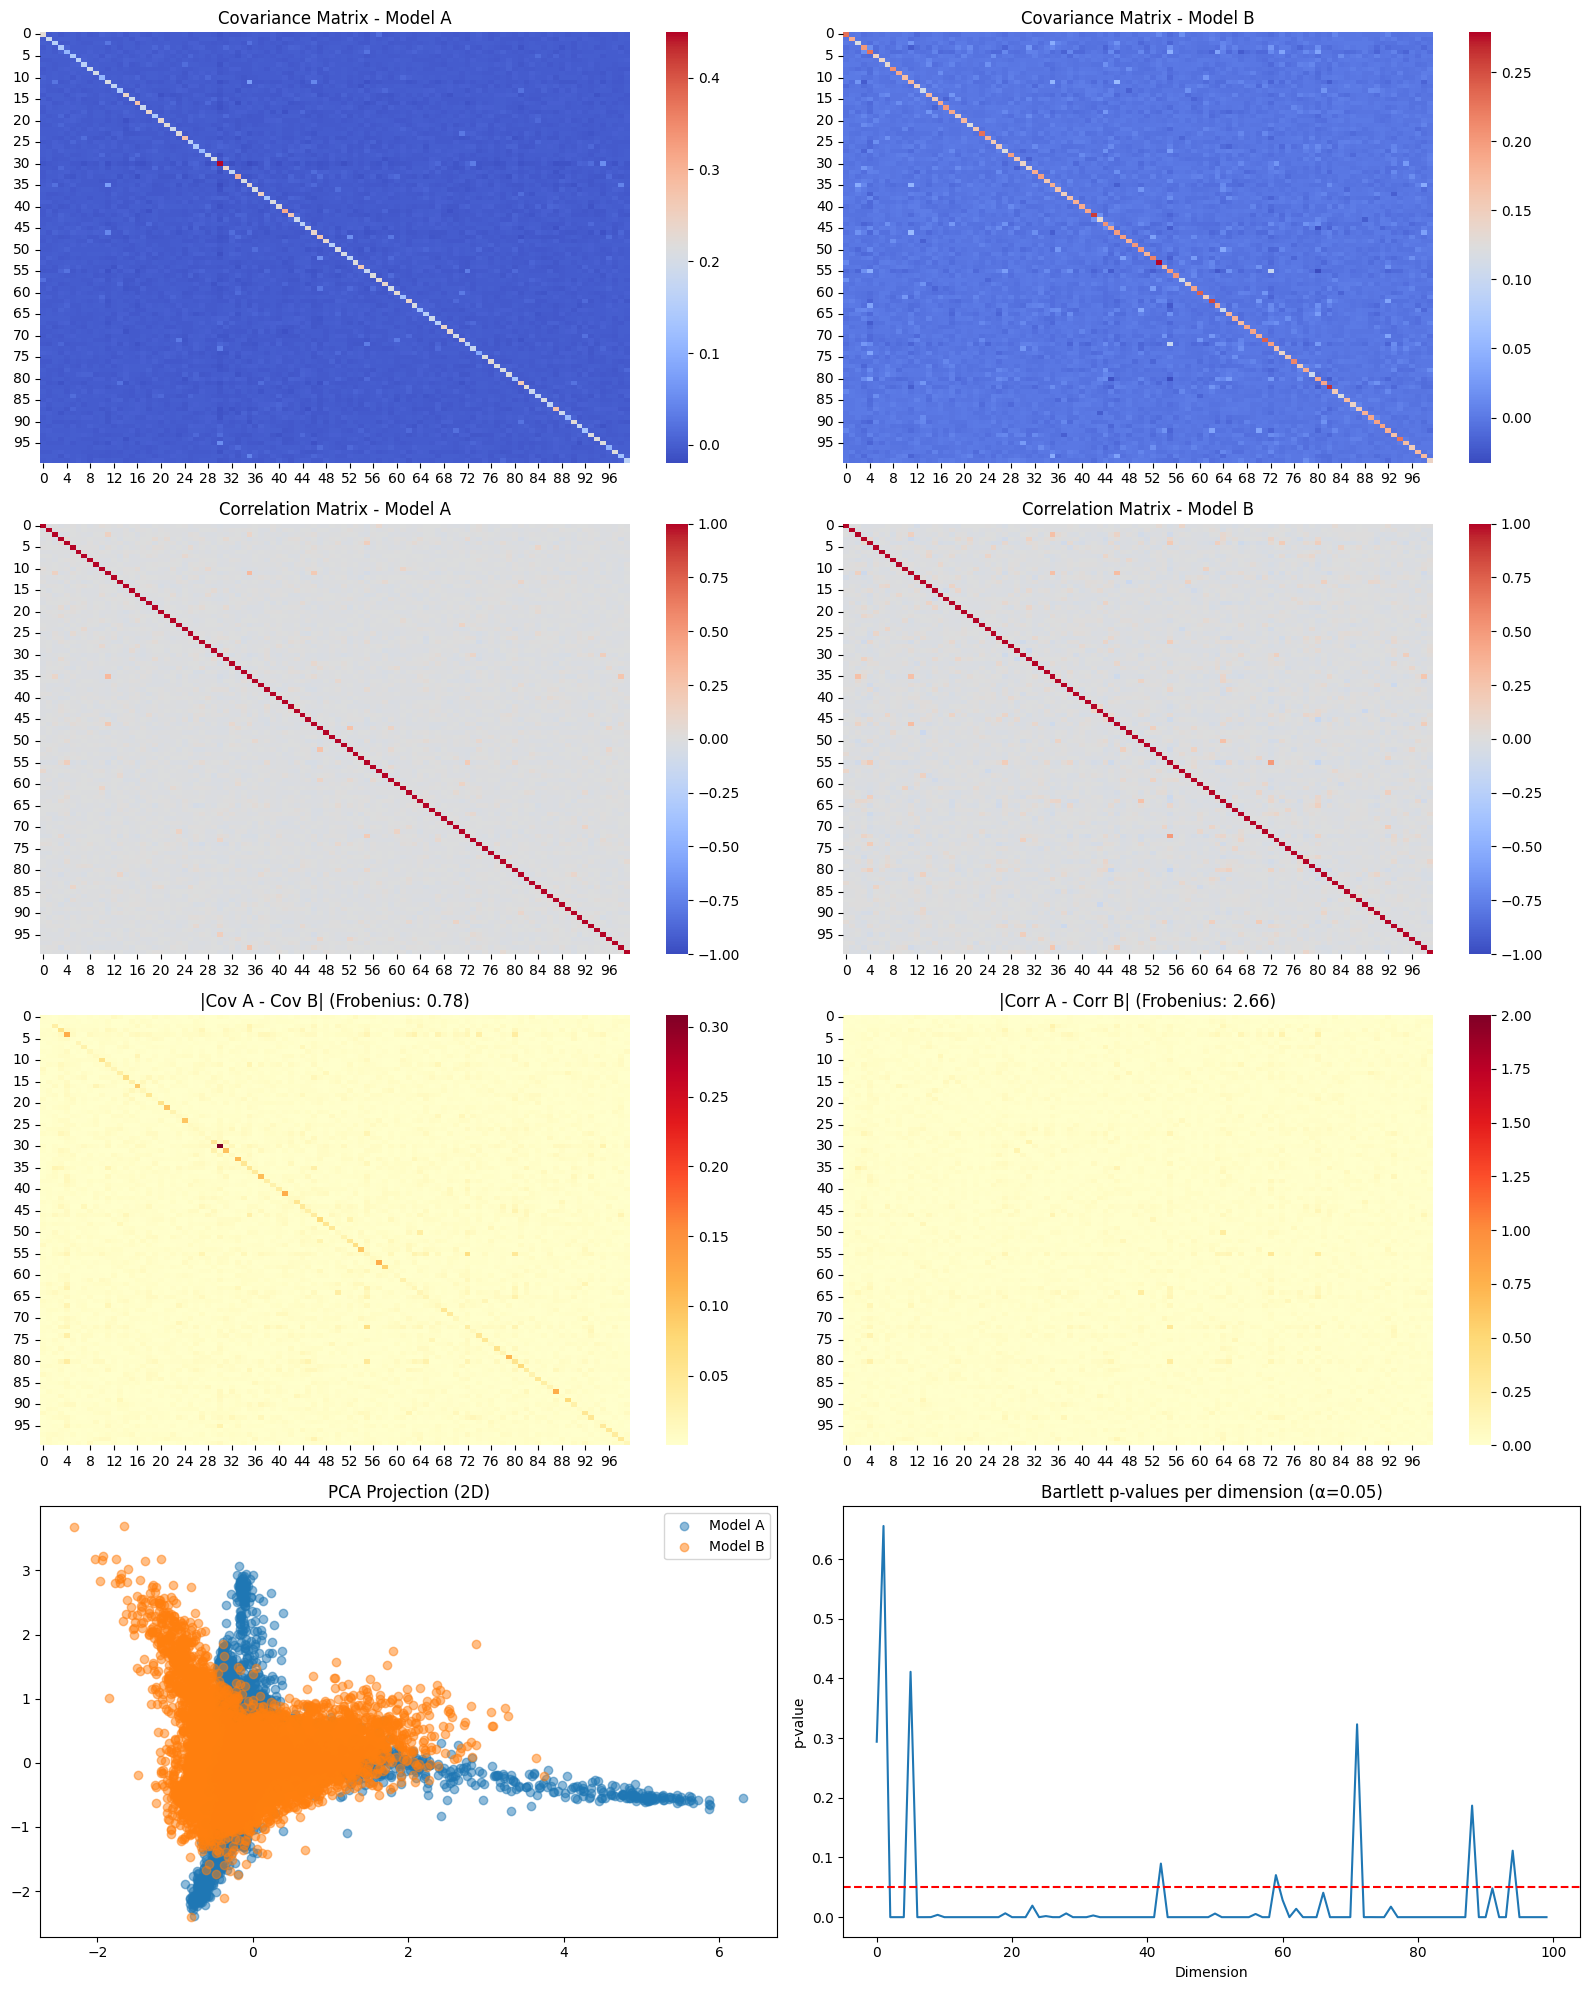

In [8]:
# Initialize the Trainer
trainer = Trainer(
    modelA=modelA,
    modelB=modelB,
    train_loader=train_loader,
    eval_loader=eval_loader,
    optimizerA=optimizerA,
    optimizerB=optimizerB,
    criterion=criterion,
    device=device
)

# Start training
trainer.train(num_epochs=num_epochs)

# Evaluate after training
trainer.test()

In [9]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained"

torch.save(modelA.state_dict(), f'{base_path}/modelA.pth')
torch.save(modelB.state_dict(), f'{base_path}/modelB.pth')

# Baseline models

In [10]:
# Define a standard CNN classifier (e.g., ResNet18) with softmax output
class SoftmaxClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes=10):
        super().__init__()
        self.features = feature_extractor
        self.head = nn.Linear(self.features.out_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)  # Logits (no softmax here; use later for scoring)
        return x

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Test Classification Report Model A:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       100
           1       0.84      0.85      0.85       100
           2       0.59      0.64      0.61       100
           3       0.68      0.54      0.60       100
           4       0.46      0.53      0.50       100
           5       0.79      0.74      0.76       100
           6       0.92      0.67      0.77       100
           7       0.78      0.72      0.75       100
           8       0.94      0.92      0.93       100
           9       0.85      0.88      0.86       100
          10       0.49      0.59      0.54       100
          11       0.43      0.48      0.45       100
          12       0.78      0.87      0.82       100
          13       0.83      0.63      0.72       100
          14       0.69      0.84      0.76       100
          15       0.77      0.77      0.77       100
          16       0.90      0.76      0.83 

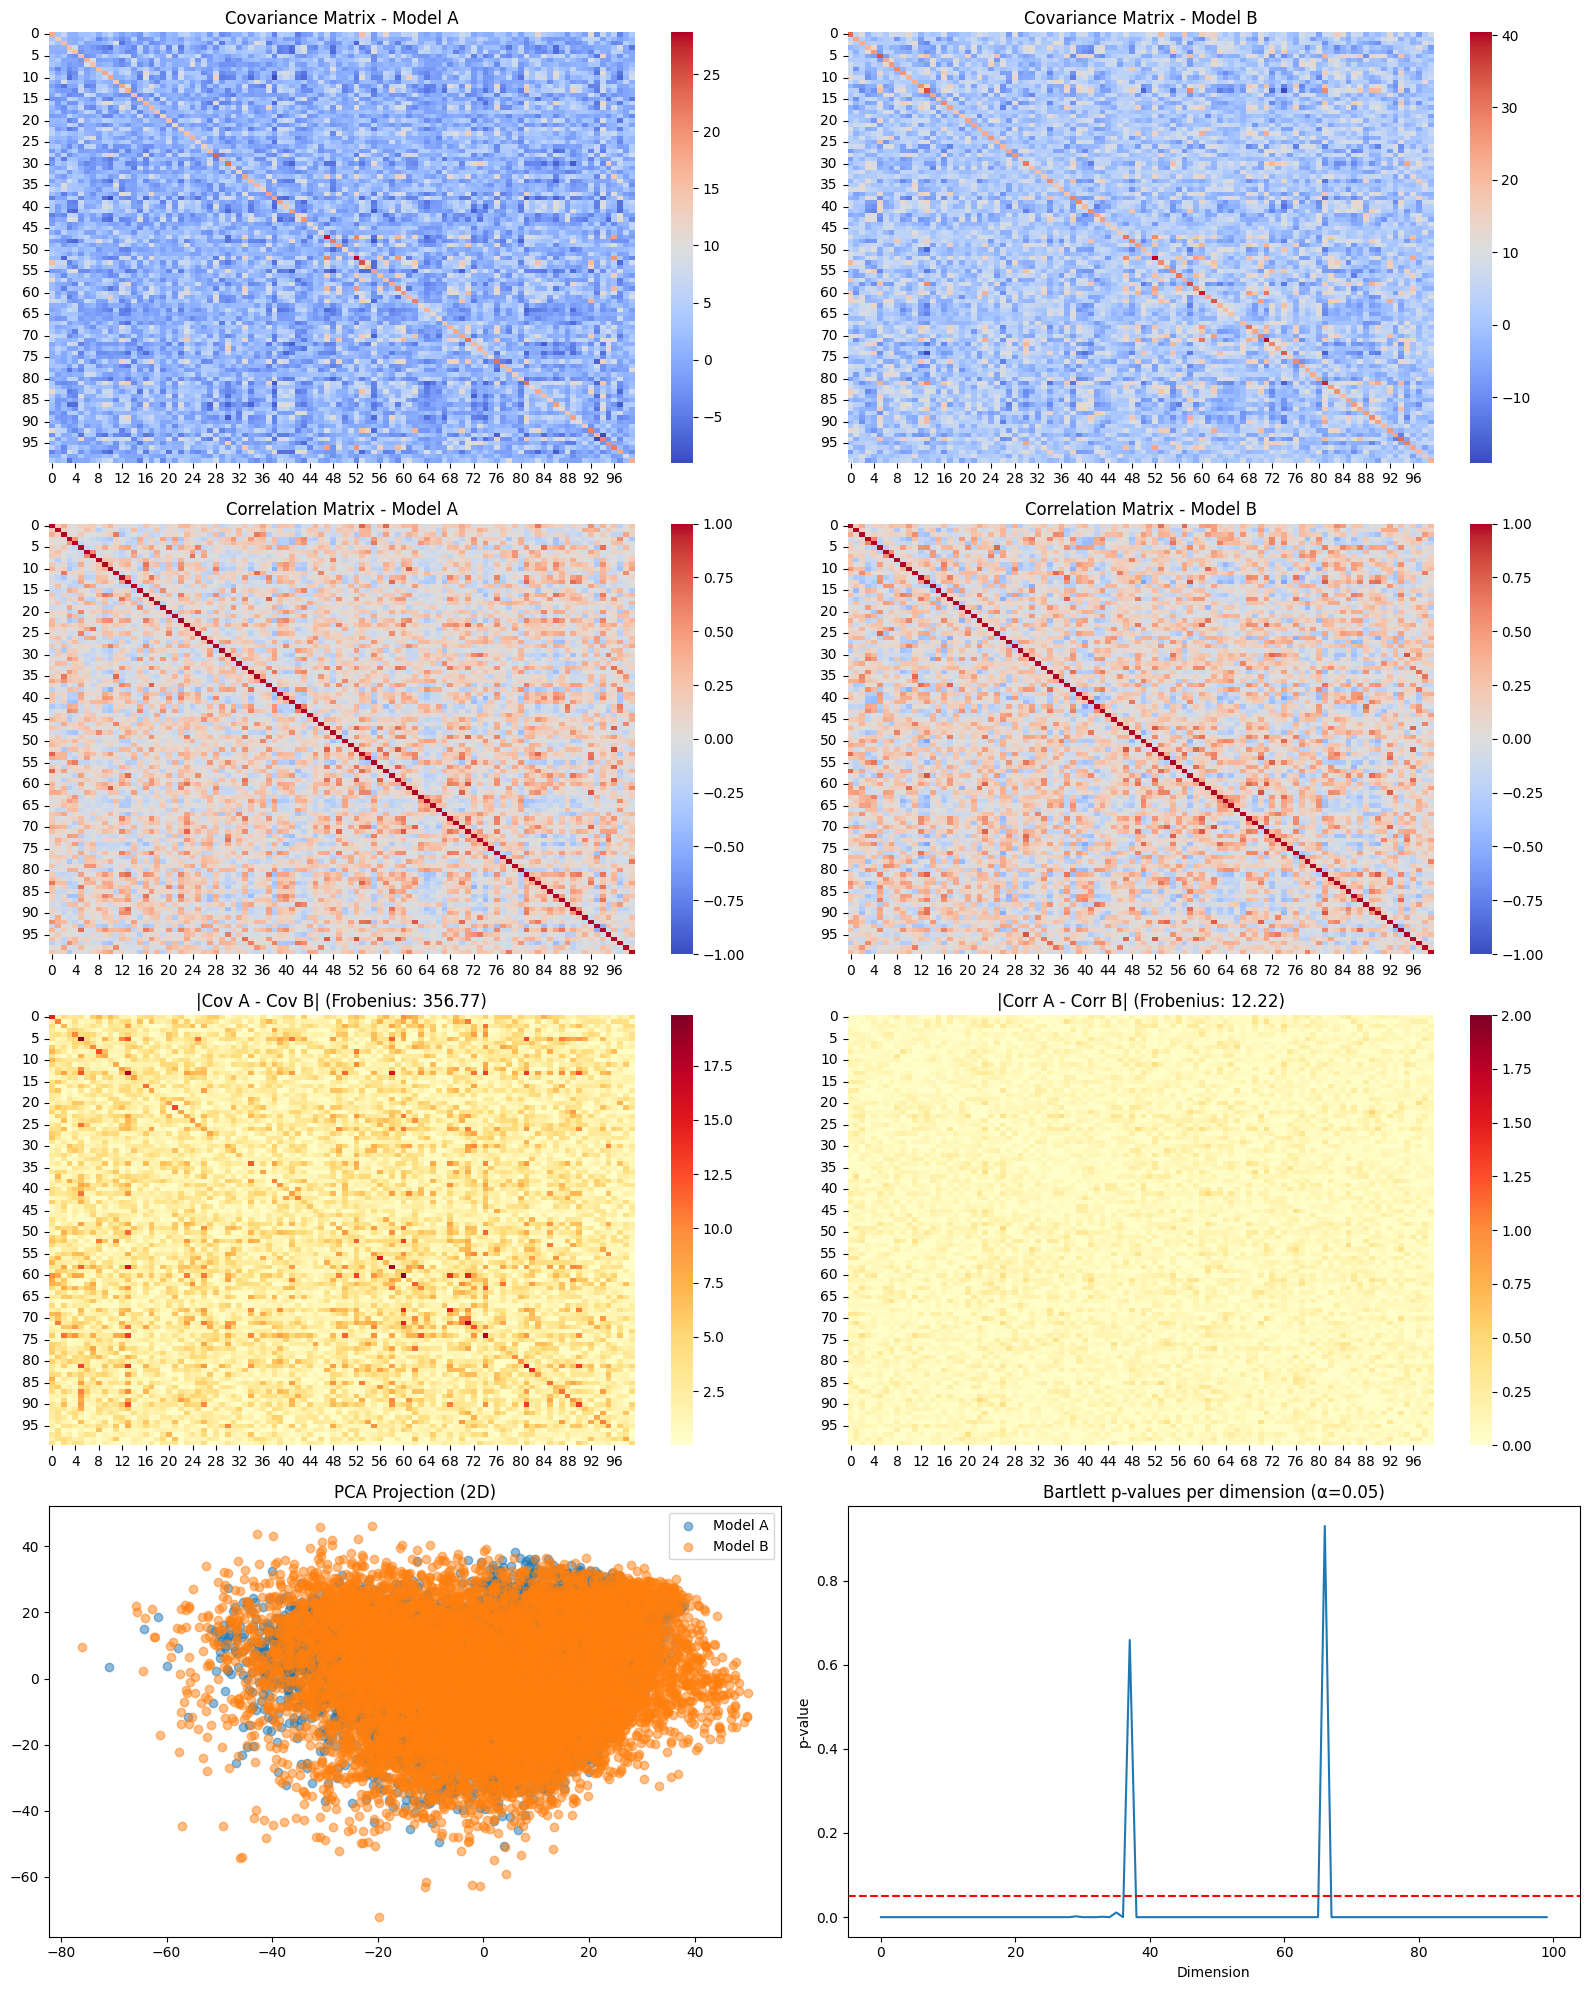

In [11]:
# Softmax model 정의 (baseline)
softmax_model = SoftmaxClassifier(ResNetFeature(), num_classes=100).to(device)
softmax_optimizer = torch.optim.Adam(softmax_model.parameters(), lr=5e-4)
softmax_criterion = nn.CrossEntropyLoss()

# KL term 제거된 ZClassifier (λ=0 ablation)
model_nokl = ZClassifier(ResNetFeature(), num_classes=100, latent_dim=60, beta=beta).to(device)
optimizer_nokl = torch.optim.Adam(model_nokl.parameters(), lr=5e-4)
criterion_nokl = lambda x, y: F.cross_entropy(x, y)  # KL 없는 버전

# Trainer 통합 구성 (Softmax vs ZClassifier without KL)
ablation_trainer = Trainer(
    modelA=softmax_model,
    modelB=model_nokl,
    train_loader=train_loader,
    eval_loader=eval_loader,
    optimizerA=softmax_optimizer,
    optimizerB=optimizer_nokl,
    criterion=criterion_nokl,  # softmax도 CE이므로 공유해도 무방
    device=device
)

# 학습 및 테스트 수행
ablation_trainer.train(num_epochs=num_epochs)
ablation_trainer.test()

In [12]:
torch.save(softmax_model.state_dict(), f'{base_path}/softmax_model.pth')
torch.save(model_nokl.state_dict(), f'{base_path}/model_nokl.pth')